Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# IMPORTS

In [1]:
pip install ucimlrepo

In [2]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    cross_val_predict, learning_curve, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier,
    StackingClassifier, VotingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from xgboost import XGBClassifier

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
# If you use McNemar test (optional, comment out if not using)
# from mlxtend.evaluate import mcnemar_table, mcnemar

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# DATA LOAD AND PREPROCESSING

In [5]:
data = fetch_ucirepo(id=728)
X = data.data.features
y = data.data.targets

y_binary = (y['Class'] == 'NonToxic').astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Class distribution:\n{y['Class'].value_counts()}")
print(f"Class balance:\n{y['Class'].value_counts(normalize=True)}")

Feature matrix shape: (171, 1203)
Target shape: (171, 1)
Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64
Class balance:
Class
NonToxic    0.672515
Toxic       0.327485
Name: proportion, dtype: float64


In [6]:
np.random.seed(42)
shuffle_idx = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
y_shuffled = y_binary.iloc[shuffle_idx].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2,
    random_state=42, stratify=y_shuffled
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

Training set: (136, 1203), Test set: (35, 1203)


In [7]:
feature_names = X.columns.tolist()

# MODEL DEFINITIONS

In [8]:
models = {
    # Linear / Penalized
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=2000, solver='lbfgs'),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=2000, solver='saga'),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=2000, solver='saga'),
    'LR_ElasticNet_L1_0.5': LogisticRegression(penalty='elasticnet', solver='saga',
                                               l1_ratio=0.5, C=1.0, max_iter=2000),
    'LR_ElasticNet_L1_0.7': LogisticRegression(penalty='elasticnet', solver='saga',
                                               l1_ratio=0.7, C=1.0, max_iter=2000),
    'Ridge_Classifier': RidgeClassifier(alpha=1.0),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=2000, random_state=42),

    # Discriminant Analysis
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),

    # Naive Bayes
    'Naive_Bayes': GaussianNB(),

    # Tree-based
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=42),
    'Decision_Tree_Unpruned': DecisionTreeClassifier(random_state=42),

    # Bagging
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Random_Forest_N200': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Random_Forest_Deep': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42),

    # Boosting
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50, random_state=42,
                                    eval_metric='logloss', use_label_encoder=False),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100, random_state=42,
                                     eval_metric='logloss', use_label_encoder=False),
    'XGBoost_D5_N100': XGBClassifier(max_depth=5, n_estimators=100, random_state=42,
                                     eval_metric='logloss', use_label_encoder=False),

    # SVM
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=42),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=42),
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=42),

    # KNN
    'KNN_K3': KNeighborsClassifier(n_neighbors=3),
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),

    # Neural Networks
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=1000, random_state=42,
                              early_stopping=True, solver='lbfgs'),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42,
                               early_stopping=True, solver='lbfgs'),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42,
                              early_stopping=True, solver='lbfgs'),
    'NN_Deep': MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42,
                             early_stopping=True, solver='lbfgs'),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42,
                             early_stopping=True, solver='adam'),
}

# BASIC SINGLE SPLIT EVALUATION

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)

    return {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }

print("\n" + "="*80)
print("TRAINING MODELS (SINGLE SPLIT)")
print("="*80)

results = []
for name, model in models.items():
    print(f"Training {name}...")
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    metrics['model'] = name
    results.append(metrics)
    print(f"  Test Accuracy: {metrics['test_acc']:.4f}, Test AUC: {metrics['test_auc']:.4f}")



TRAINING MODELS (SINGLE SPLIT)
Training LR_No_Penalty...
  Test Accuracy: 0.6000, Test AUC: 0.5833
Training LR_Ridge_C1...
  Test Accuracy: 0.5714, Test AUC: 0.5682
Training LR_Ridge_C0.1...
  Test Accuracy: 0.5714, Test AUC: 0.5758
Training LR_Ridge_C10...
  Test Accuracy: 0.5429, Test AUC: 0.5530
Training LR_Lasso_C1...
  Test Accuracy: 0.6000, Test AUC: 0.5455
Training LR_Lasso_C0.1...
  Test Accuracy: 0.6857, Test AUC: 0.5644
Training LR_ElasticNet_L1_0.5...
  Test Accuracy: 0.6000, Test AUC: 0.5417
Training LR_ElasticNet_L1_0.7...
  Test Accuracy: 0.6000, Test AUC: 0.5417
Training Ridge_Classifier...
  Test Accuracy: 0.5143, Test AUC: 0.5492
Training SGD_Classifier...
  Test Accuracy: 0.5714, Test AUC: 0.4924
Training LDA...
  Test Accuracy: 0.6000, Test AUC: 0.5473
Training QDA...
  Test Accuracy: 0.6286, Test AUC: 0.6307
Training Naive_Bayes...
  Test Accuracy: 0.4286, Test AUC: 0.5076
Training Decision_Tree_D5...
  Test Accuracy: 0.6286, Test AUC: 0.5795
Training Decision_Tree

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'train_acc', 'test_acc', 'train_auc',
                         'test_auc', 'precision', 'recall', 'f1']]
results_df = results_df.sort_values('test_acc', ascending=False).reset_index(drop=True)

print("\n=== MODEL COMPARISON (SINGLE SPLIT) ===")
print(results_df.to_string(index=False))

# CROSS-VALIDATION EVALUATION

In [10]:
def evaluate_model_cv(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    acc_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    auc_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1', n_jobs=-1)
    precision_scores = cross_val_score(model, X, y, cv=skf, scoring='precision', n_jobs=-1)
    recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall', n_jobs=-1)

    return {
        'acc_mean': acc_scores.mean(),
        'acc_std': acc_scores.std(),
        'auc_mean': auc_scores.mean(),
        'auc_std': auc_scores.std(),
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'precision_mean': precision_scores.mean(),
        'precision_std': precision_scores.std(),
        'recall_mean': recall_scores.mean(),
        'recall_std': recall_scores.std()
    }

print("\n" + "="*80)
print("CROSS-VALIDATION (5-FOLD STRATIFIED)")
print("="*80)

cv_results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model_cv(model, X_train_scaled, y_train, cv=5)
    metrics['model'] = name
    cv_results.append(metrics)
    print(f"  AUC: {metrics['auc_mean']:.4f} ± {metrics['auc_std']:.4f}")

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('auc_mean', ascending=False).reset_index(drop=True)

print("\n=== CROSS-VALIDATION RESULTS ===")
print(cv_results_df[['model', 'acc_mean', 'acc_std',
                     'auc_mean', 'auc_std', 'f1_mean', 'f1_std']].to_string(index=False))


CROSS-VALIDATION (5-FOLD STRATIFIED)
Evaluating LR_No_Penalty...
  AUC: 0.3951 ± 0.1620
Evaluating LR_Ridge_C1...
  AUC: 0.4211 ± 0.1615
Evaluating LR_Ridge_C0.1...
  AUC: 0.4190 ± 0.1561
Evaluating LR_Ridge_C10...
  AUC: 0.4284 ± 0.1666
Evaluating LR_Lasso_C1...
  AUC: 0.3773 ± 0.1443
Evaluating LR_Lasso_C0.1...
  AUC: 0.4252 ± 0.1501
Evaluating LR_ElasticNet_L1_0.5...
  AUC: 0.3975 ± 0.1549
Evaluating LR_ElasticNet_L1_0.7...
  AUC: 0.3990 ± 0.1485
Evaluating Ridge_Classifier...
  AUC: 0.4372 ± 0.1521
Evaluating SGD_Classifier...
  AUC: 0.4450 ± 0.1785
Evaluating LDA...
  AUC: 0.4539 ± 0.1179
Evaluating QDA...
  AUC: 0.5104 ± 0.0829
Evaluating Naive_Bayes...
  AUC: 0.3979 ± 0.0896
Evaluating Decision_Tree_D5...
  AUC: 0.4726 ± 0.0948
Evaluating Decision_Tree_D10...
  AUC: 0.4848 ± 0.1231
Evaluating Decision_Tree_D20...
  AUC: 0.4848 ± 0.1231
Evaluating Decision_Tree_Unpruned...
  AUC: 0.4848 ± 0.1231
Evaluating Random_Forest_N50...
  AUC: 0.3992 ± 0.0917
Evaluating Random_Forest_N100

In [27]:
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('auc_mean', ascending=False).reset_index(drop=True)

print("\n=== CROSS-VALIDATION RESULTS ===")
print(cv_results_df[['model', 'acc_mean', 'acc_std',
                     'auc_mean', 'auc_std', 'f1_mean', 'f1_std']].to_string(index=False))


=== CROSS-VALIDATION RESULTS ===
                 model  acc_mean  acc_std  auc_mean  auc_std  f1_mean   f1_std
                KNN_K7  0.623810 0.091680  0.519948 0.149643 0.741429 0.069000
                   QDA  0.515344 0.046440  0.510396 0.082895 0.592552 0.040729
                KNN_K5  0.602381 0.070350  0.504191 0.123131 0.720890 0.051182
               KNN_K10  0.521958 0.033833  0.495776 0.103237 0.649677 0.043847
     Decision_Tree_D20  0.535714 0.138180  0.484795 0.123105 0.635810 0.140334
     Decision_Tree_D10  0.535714 0.138180  0.484795 0.123105 0.635810 0.140334
Decision_Tree_Unpruned  0.535714 0.138180  0.484795 0.123105 0.635810 0.140334
                KNN_K3  0.521958 0.052828  0.475926 0.048777 0.655491 0.041063
      Decision_Tree_D5  0.543122 0.118829  0.472612 0.094796 0.647993 0.115363
          AdaBoost_N50  0.558466 0.079279  0.460559 0.089057 0.669591 0.072262
                   LDA  0.536243 0.108083  0.453931 0.117888 0.631407 0.131557
        XGBoost_D3

# MODEL GROUPING

In [11]:
def assign_model_group(name):
    categories = {
        'Linear / Penalized': ['LR_', 'Ridge_Classifier', 'SGD_Classifier'],
        'Single Tree': ['Decision_Tree'],
        'Random Forest / ExtraTrees': ['Random_Forest', 'Extra_Trees'],
        'Boosting Ensembles': ['AdaBoost', 'GradientBoosting', 'XGBoost'],
        'SVM': ['SVM_'],
        'KNN': ['KNN_'],
        'Neural Networks': ['NN_'],
        'Discriminant Analysis': ['LDA', 'QDA'],
        'Naive Bayes': ['Naive_Bayes']
    }
    for group, keywords in categories.items():
        if any(k in name for k in keywords):
            return group
    return 'Other'

results_df['Group'] = results_df['model'].apply(assign_model_group)
cv_results_df['Group'] = cv_results_df['model'].apply(assign_model_group)

# FEATURE IMPORTANCE AND COMPARISON

In [12]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 'SpMax7_Bhe',
                     'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 'SpMax5_Bhv',
                     'VE3_Dzi', 'VPC-4']

In [13]:
def get_feature_importance(model, X_train, X_test, y_train, y_test):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        method = "Built-in"
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        method = "Coefficients"
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10,
            random_state=42, n_jobs=-1
        )
        importances = perm_importance.importances_mean
        method = "Permutation"
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    return importance_df, method

print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)
print(f"Original study features ({len(original_features)}):")
print(original_features)


FEATURE IMPORTANCE COMPARISON
Original study features (13):
['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']


In [ ]:
feature_comparison = {}
for name, model in models.items():
    print(f"\n### {name} ###")
    # Ensure model is fitted
    model.fit(X_train_scaled, y_train)
    importance_df, method = get_feature_importance(
        model, X_train_scaled, X_test_scaled, y_train, y_test
    )
    top_13 = importance_df.head(13)
    top_13_features = top_13['feature'].tolist()
    overlap = set(top_13_features) & set(original_features)
    overlap_count = len(overlap)
    overlap_pct = (overlap_count / len(original_features)) * 100

    print(f"Method: {method}")
    print(f"Overlap with original: {overlap_count}/{len(original_features)} ({overlap_pct:.1f}%)")
    if overlap:
        print(f"Matching: {sorted(overlap)}")

    feature_comparison[name] = {
        'top_13': top_13_features,
        'overlap_count': overlap_count,
        'overlap_features': sorted(overlap),
        'method': method
    }


### LR_No_Penalty ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_Ridge_C1 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_Ridge_C0.1 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_Ridge_C10 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_Lasso_C1 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_Lasso_C0.1 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_ElasticNet_L1_0.5 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LR_ElasticNet_L1_0.7 ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### Ridge_Classifier ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### SGD_Classifier ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### LDA ###
Method: Coefficients
Overlap with original: 0/13 (0.0%)

### QDA ###
Method: Permutation
Overlap with original: 0/13 (0.0%)

### Naive_Bayes ###
Method: Permutation
Overlap with origin

In [26]:
summary_df = pd.DataFrame({
    'Model': list(feature_comparison.keys()),
    'Overlap Count': [v['overlap_count'] for v in feature_comparison.values()],
    'Overlap %': [(v['overlap_count'] / len(original_features)) * 100
                  for v in feature_comparison.values()],
    'Method': [v['method'] for v in feature_comparison.values()]
}).sort_values('Overlap Count', ascending=False)

print("\n=== SUMMARY: OVERLAP WITH ORIGINAL STUDY ===")
print(summary_df.to_string(index=False))


=== SUMMARY: OVERLAP WITH ORIGINAL STUDY ===
                 Model  Overlap Count  Overlap %       Method
          AdaBoost_N50              2  15.384615     Built-in
         AdaBoost_N100              1   7.692308     Built-in
              NN_Large              1   7.692308  Permutation
             NN_Medium              1   7.692308  Permutation
           LR_Lasso_C1              0   0.000000 Coefficients
         LR_Lasso_C0.1              0   0.000000 Coefficients
  LR_ElasticNet_L1_0.5              0   0.000000 Coefficients
          LR_Ridge_C10              0   0.000000 Coefficients
         LR_No_Penalty              0   0.000000 Coefficients
           LR_Ridge_C1              0   0.000000 Coefficients
         LR_Ridge_C0.1              0   0.000000 Coefficients
                   LDA              0   0.000000 Coefficients
        SGD_Classifier              0   0.000000 Coefficients
      Ridge_Classifier              0   0.000000 Coefficients
  LR_ElasticNet_L1_0.7  

# FEATURE CONSISTENCY

In [15]:
all_top_features = []
for comp in feature_comparison.values():
    all_top_features.extend(comp['top_13'])

feature_counts = pd.Series(all_top_features).value_counts()
frequent_features = feature_counts[feature_counts >= 3]

print("\n" + "="*80)
print("FEATURES SELECTED BY 3+ MODELS")
print("="*80)
if len(frequent_features) > 0:
    for feat, count in frequent_features.items():
        in_original = "✓" if feat in original_features else " "
        print(f"[{in_original}] {feat}: {count}/{len(models)} models")
else:
    print("No features selected by ≥3 models.")

comparison_results = []
for model_name, comp in feature_comparison.items():
    for i, feat in enumerate(comp['top_13'], 1):
        comparison_results.append({
            'model': model_name,
            'rank': i,
            'feature': feat,
            'in_original_study': feat in original_features
        })
comparison_df = pd.DataFrame(comparison_results)


FEATURES SELECTED BY 3+ MODELS
[ ] minssNH: 12/43 models
[ ] SpDiam_Dt: 12/43 models
[ ] maxssNH: 10/43 models
[ ] maxHaaCH: 10/43 models
[ ] ALogp2: 9/43 models
[ ] MATS1s: 8/43 models
[ ] AATSC4m: 8/43 models
[ ] minsF: 8/43 models
[ ] nBase: 8/43 models
[ ] ATSC3v: 8/43 models
[ ] MDEO-22: 7/43 models
[ ] maxHBint4: 7/43 models
[ ] maxsF: 7/43 models
[ ] VE1_D: 7/43 models
[ ] JGI7: 7/43 models
[ ] C3SP3: 7/43 models
[ ] MATS3v: 7/43 models
[ ] maxsssCH: 7/43 models
[ ] minHCsatu: 6/43 models
[ ] VE3_D: 6/43 models
[ ] AATSC1s: 6/43 models
[ ] minHBint4: 6/43 models
[ ] AATSC1c: 6/43 models
[ ] nHBint10: 6/43 models
[ ] nsCl: 6/43 models
[ ] AATSC1v: 6/43 models
[ ] VE1_Dt: 6/43 models
[ ] ATS5v: 6/43 models
[ ] nHBAcc: 6/43 models
[ ] AATSC1m: 6/43 models
[ ] MATS5i: 5/43 models
[ ] topoShape: 5/43 models
[ ] maxHBint5: 5/43 models
[ ] SpMax4_Bhm: 5/43 models
[ ] ATS3m: 5/43 models
[ ] MATS6i: 4/43 models
[ ] nHBint3: 4/43 models
[ ] ATS2p: 4/43 models
[ ] VE2_Dzp: 4/43 models
[ ]

# VISUALIZATIONS

## PERFORMANCE

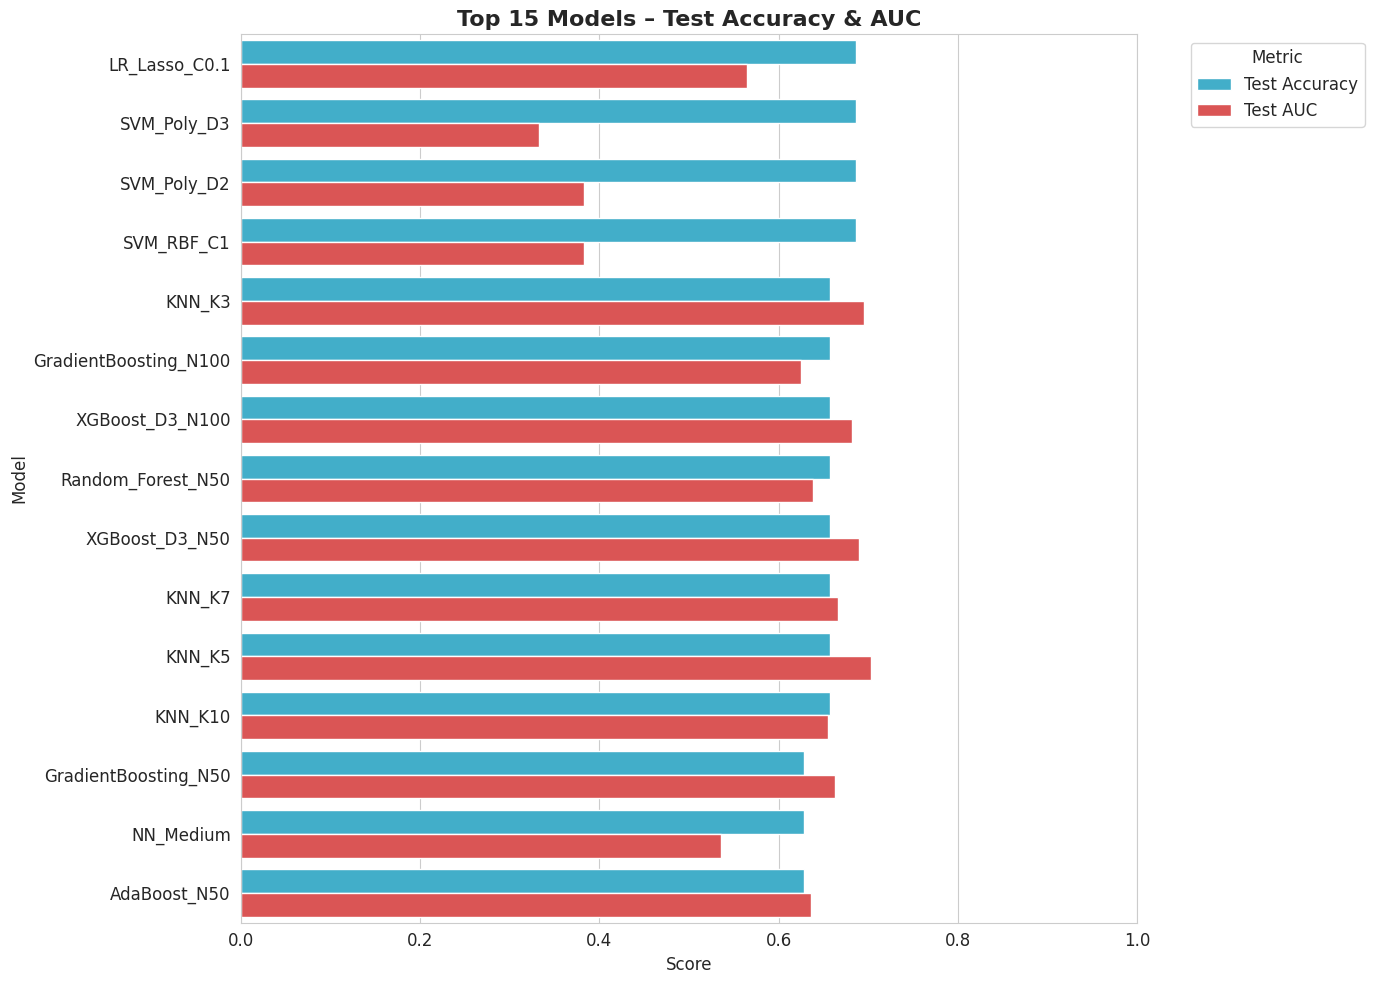

In [16]:
def plot_top_models(results_df, n=15):
    top_n = results_df.head(n).copy()
    plot_data = top_n.melt(
        id_vars=['model', 'Group'],
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric',
        value_name='Score'
    )
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.barplot(
        data=plot_data, y='model', x='Score', hue='Metric',
        dodge=True, ax=ax,
        palette={'test_acc': "#2bbbdf", 'test_auc': "#f03f3f"}
    )
    ax.set_title(f'Top {n} Models – Test Accuracy & AUC', fontsize=16, weight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Model')
    ax.set_xlim(0, 1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'],
              title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_top_models(results_df, n=15)

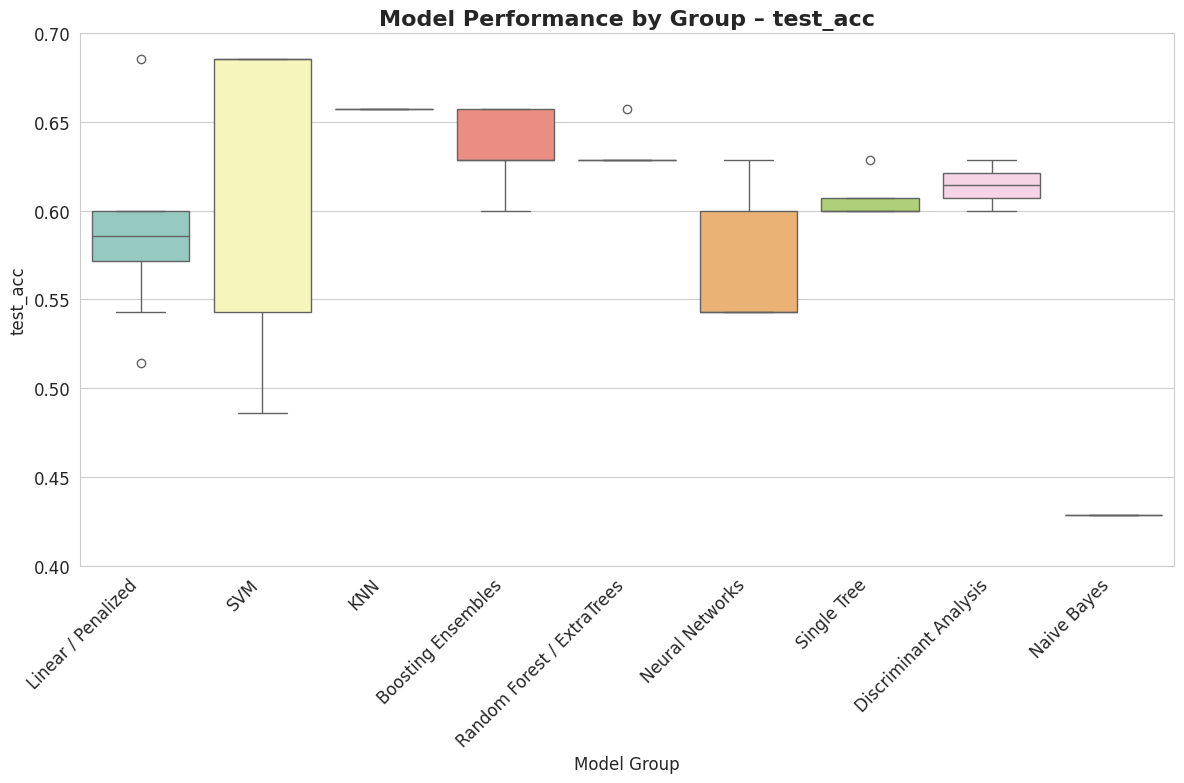

In [29]:
def plot_grouped_boxplot(results_df, metric='test_acc'):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(data=results_df, x='Group', y=metric, palette='Set3', ax=ax)
    ax.set_title(f'Model Performance by Group – {metric}', fontsize=16, weight='bold')
    ax.set_xlabel('Model Group')
    ax.set_ylabel(metric)
    ax.set_ylim(0.4, 0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_grouped_boxplot(results_df, metric='test_acc')

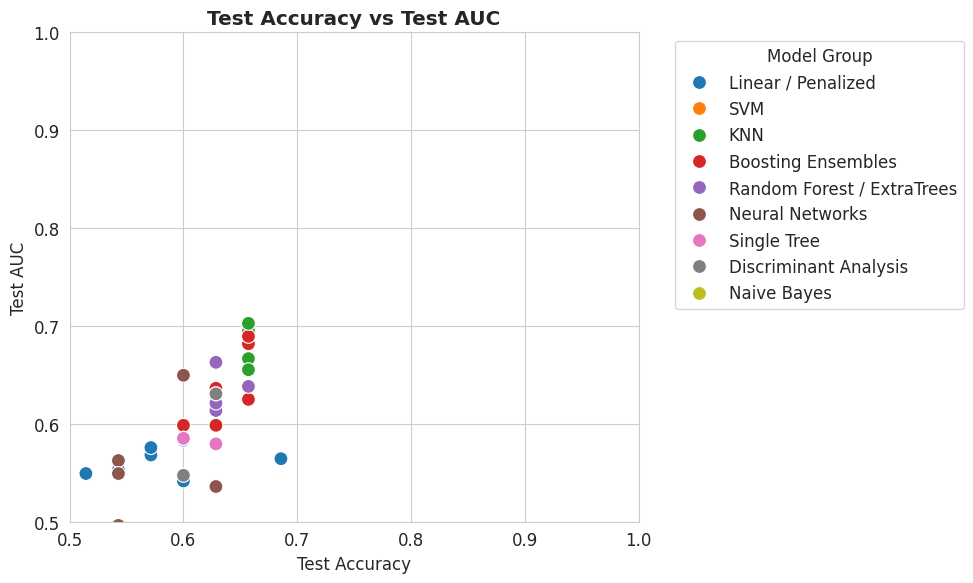

In [18]:
def plot_accuracy_vs_auc(results_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='test_acc', y='test_auc',
                    hue='Group', s=100, palette='tab10')
    plt.title('Test Accuracy vs Test AUC', weight='bold')
    plt.xlabel('Test Accuracy')
    plt.ylabel('Test AUC')
    plt.xlim(0.5, 1)
    plt.ylim(0.5, 1)
    plt.legend(title='Model Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_accuracy_vs_auc(results_df)

## FEATURE CONSISTENCY

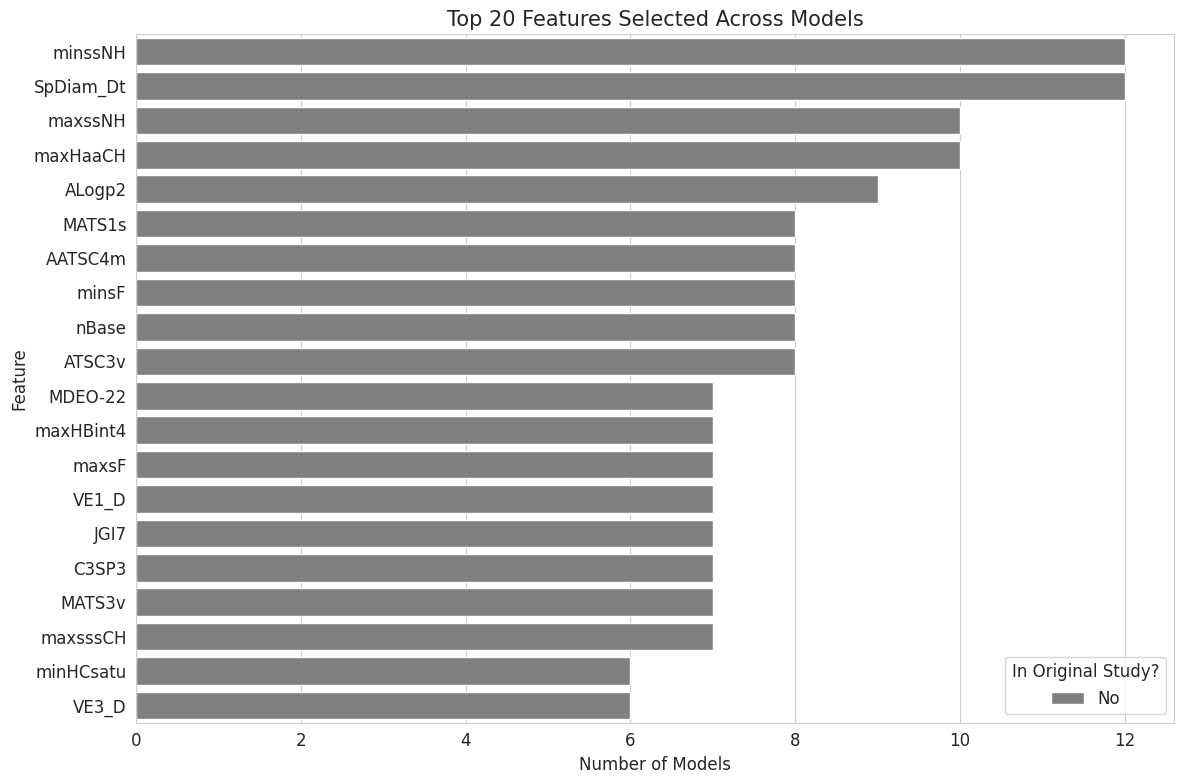

In [19]:
def plot_feature_consistency(feature_comparison, original_features, top_n=20):
    all_top_features = []
    for comp in feature_comparison.values():
        all_top_features.extend(comp['top_13'])
    feat_counts = pd.Series(all_top_features).value_counts().head(top_n)
    feat_df = feat_counts.reset_index()
    feat_df.columns = ['Feature', 'Frequency']
    feat_df['In_Original_Study'] = feat_df['Feature'].apply(
        lambda x: 'Yes' if x in original_features else 'No'
    )
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Feature', data=feat_df,
                hue='In_Original_Study', dodge=False,
                palette={'Yes': 'green', 'No': 'gray'})
    plt.title(f'Top {top_n} Features Selected Across Models', fontsize=15)
    plt.xlabel('Number of Models')
    plt.legend(title='In Original Study?')
    plt.tight_layout()
    plt.show()

plot_feature_consistency(feature_comparison, original_features, top_n=20)

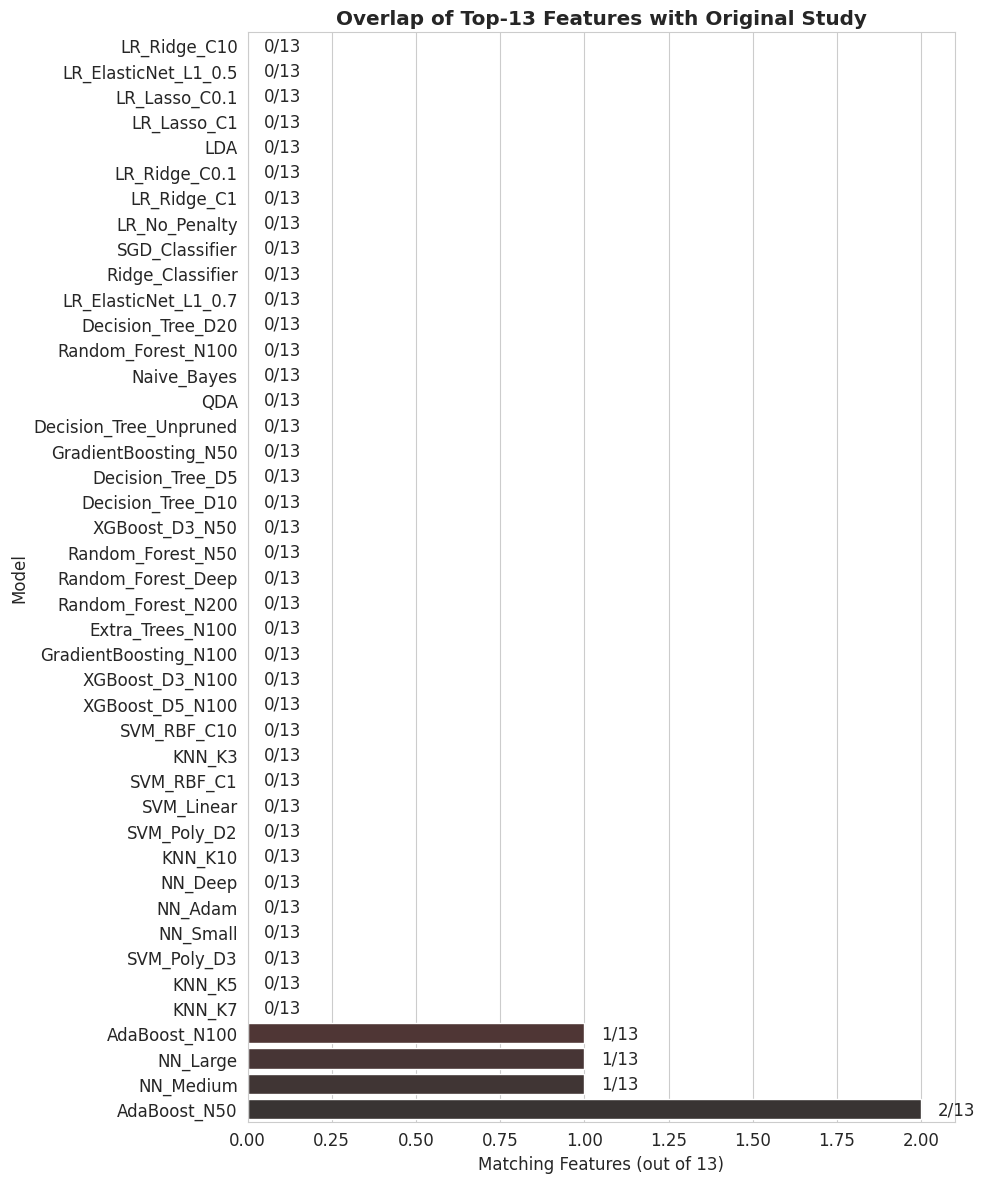

In [20]:
def plot_feature_overlap(summary_df):
    overlap_df = summary_df.sort_values('Overlap Count', ascending=True)
    plt.figure(figsize=(10, 12))
    sns.barplot(data=overlap_df, y='Model', x='Overlap Count', palette='Reds_d')
    plt.title('Overlap of Top-13 Features with Original Study', weight='bold')
    plt.xlabel('Matching Features (out of 13)')
    for i, row in enumerate(overlap_df.itertuples()):
        plt.text(row._2 + 0.05, i, f'{row._2}/13', va='center')
    plt.tight_layout()
    plt.show()

plot_feature_overlap(summary_df)

## CROSS-VALIDATION STABILITY PLOT

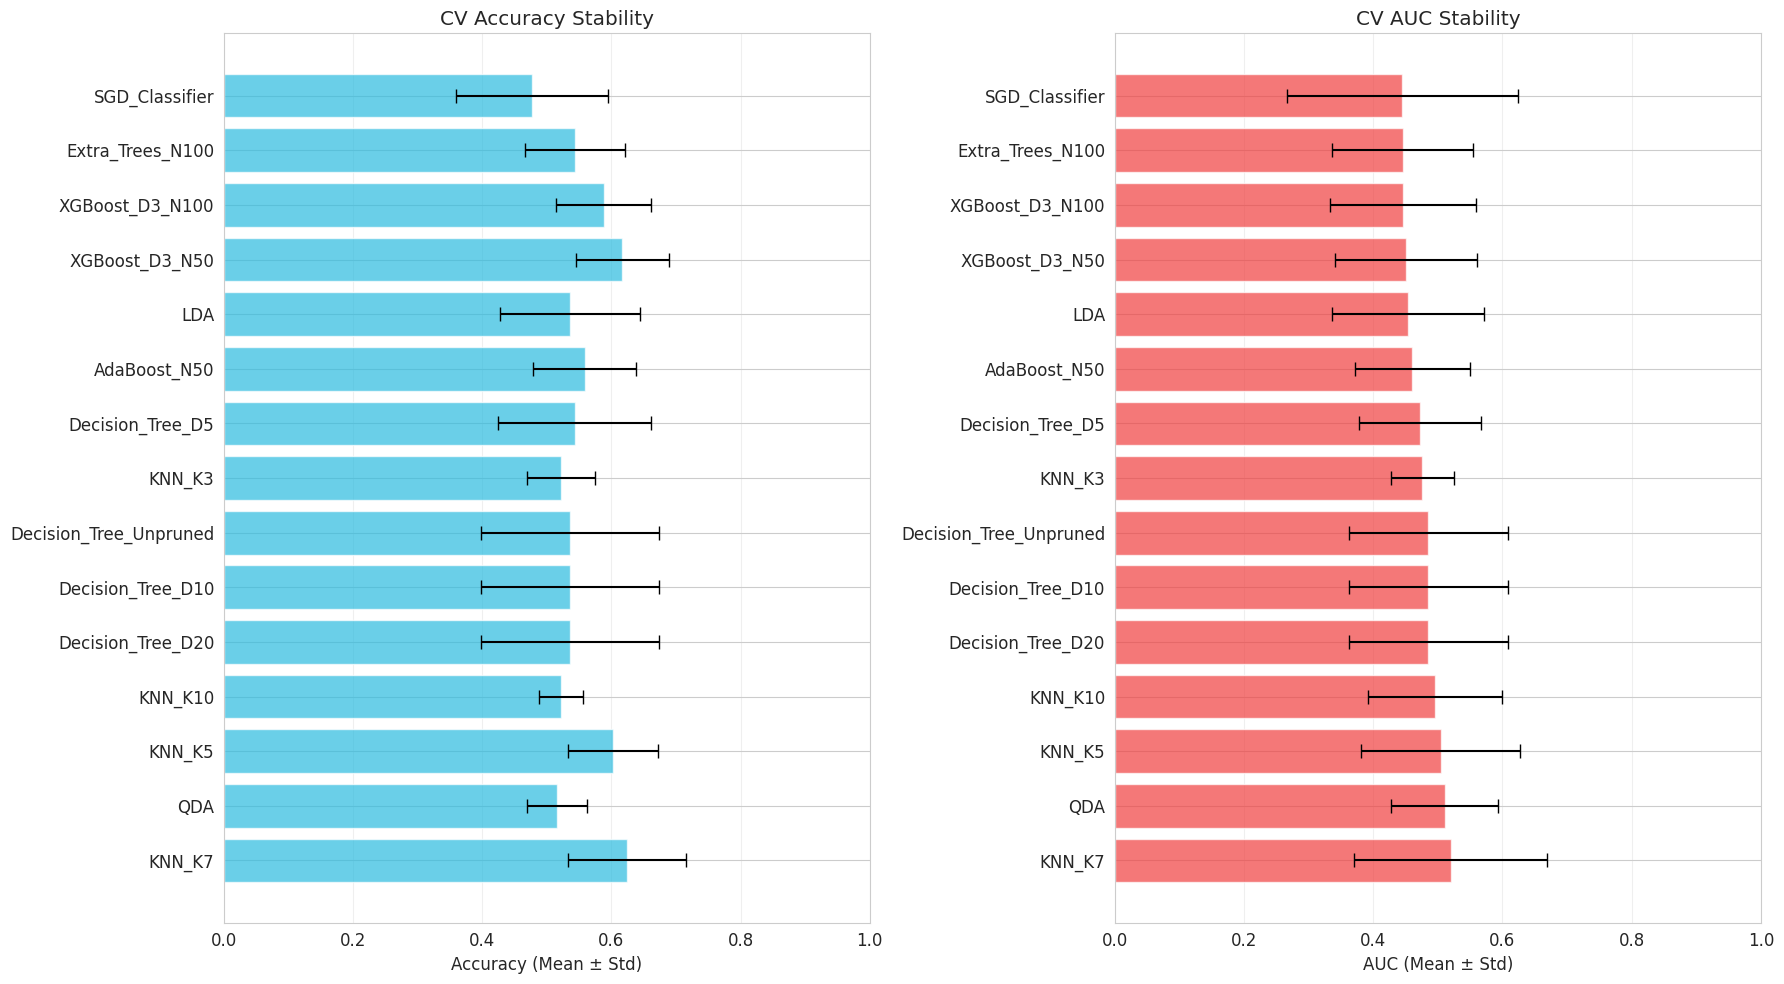

In [21]:
def plot_cv_performance_with_errors(cv_results_df, n=15):
    top_n = cv_results_df.head(n).copy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

    ax1.barh(range(len(top_n)), top_n['acc_mean'],
             xerr=top_n['acc_std'], capsize=5, color='#2bbbdf', alpha=0.7)
    ax1.set_yticks(range(len(top_n)))
    ax1.set_yticklabels(top_n['model'])
    ax1.set_xlabel('Accuracy (Mean ± Std)')
    ax1.set_title('CV Accuracy Stability')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)

    ax2.barh(range(len(top_n)), top_n['auc_mean'],
             xerr=top_n['auc_std'], capsize=5, color='#f03f3f', alpha=0.7)
    ax2.set_yticks(range(len(top_n)))
    ax2.set_yticklabels(top_n['model'])
    ax2.set_xlabel('AUC (Mean ± Std)')
    ax2.set_title('CV AUC Stability')
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_cv_performance_with_errors(cv_results_df, n=15)

## OVERFITTING SCATTER (TRAIN VS TEST)

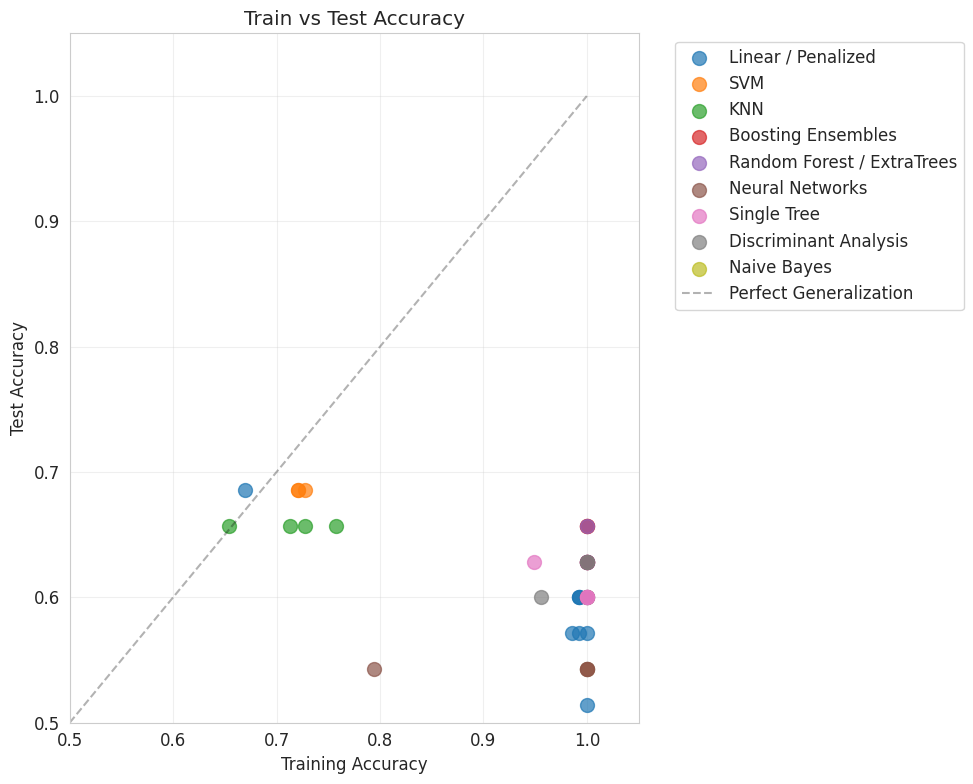


Models with highest overfitting:
           model  overfitting_gap
     SVM_RBF_C10         0.514286
Ridge_Classifier         0.485714
    LR_Ridge_C10         0.457143
         NN_Deep         0.457143
      SVM_Linear         0.457143


In [22]:
def plot_train_vs_test_scatter(results_df):
    plt.figure(figsize=(10, 8))
    for group in results_df['Group'].unique():
        group_data = results_df[results_df['Group'] == group]
        plt.scatter(group_data['train_acc'], group_data['test_acc'],
                    label=group, s=100, alpha=0.7)
    plt.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, label='Perfect Generalization')
    plt.xlabel('Training Accuracy')
    plt.ylabel('Test Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0.5, 1.05)
    plt.ylim(0.5, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    results_df['overfitting_gap'] = results_df['train_acc'] - results_df['test_acc']
    worst_overfitters = results_df.nlargest(5, 'overfitting_gap')[['model', 'overfitting_gap']]
    print("\nModels with highest overfitting:")
    print(worst_overfitters.to_string(index=False))

plot_train_vs_test_scatter(results_df)

## LEARNING CURVES FOR TOP MODELS


LEARNING CURVES - TOP 5 MODELS


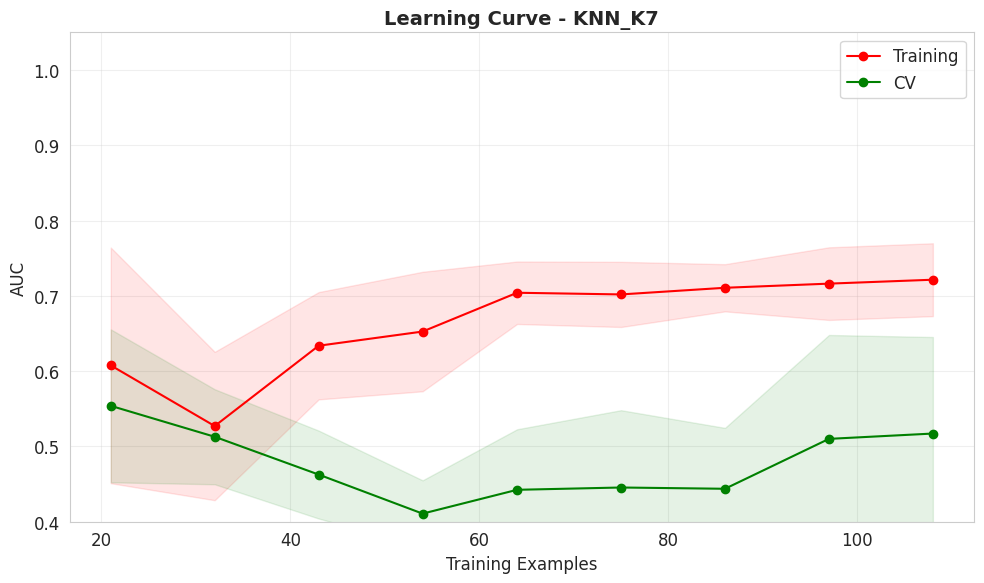

KNN_K7: Overfitting gap = 0.2043


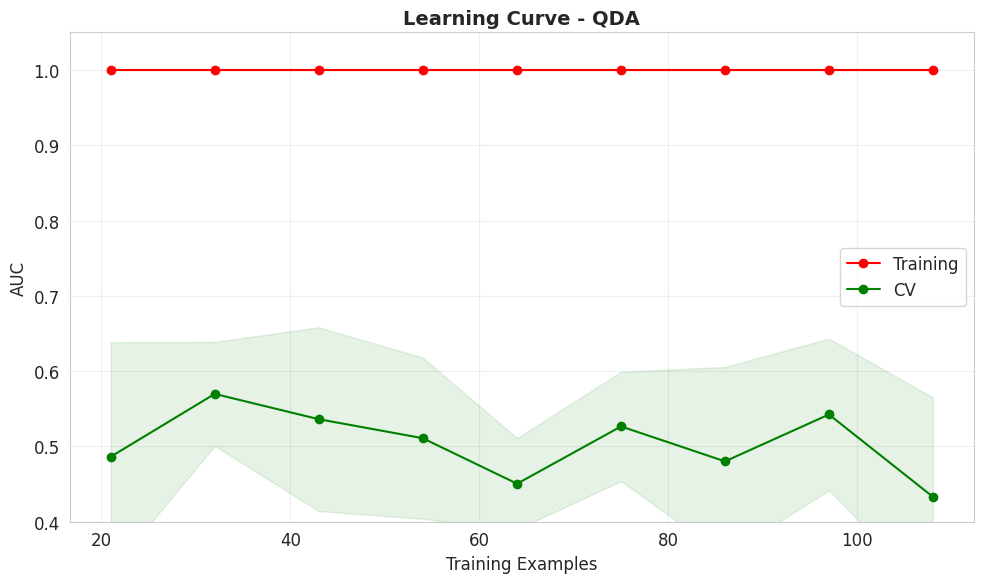

QDA: Overfitting gap = 0.5669


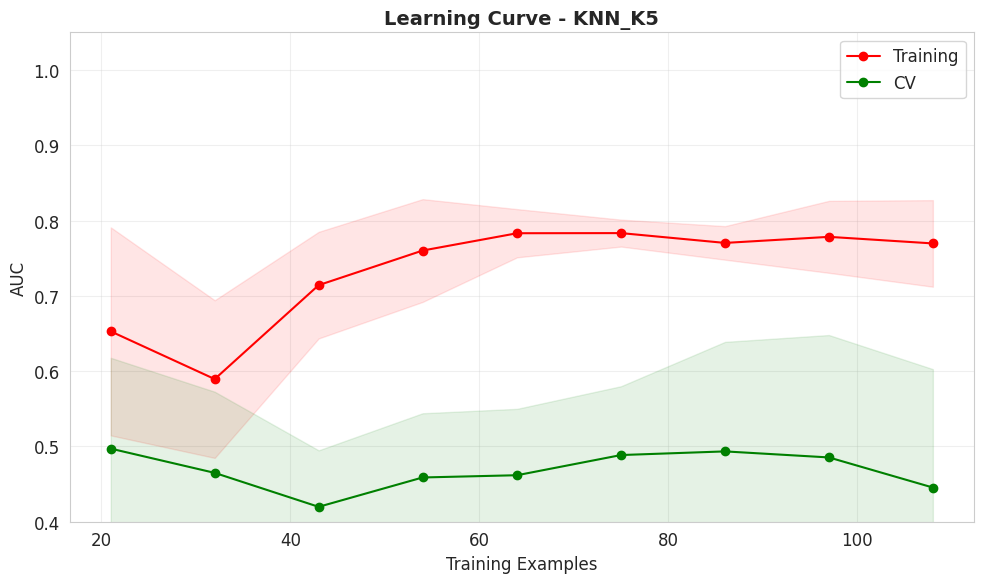

KNN_K5: Overfitting gap = 0.3242


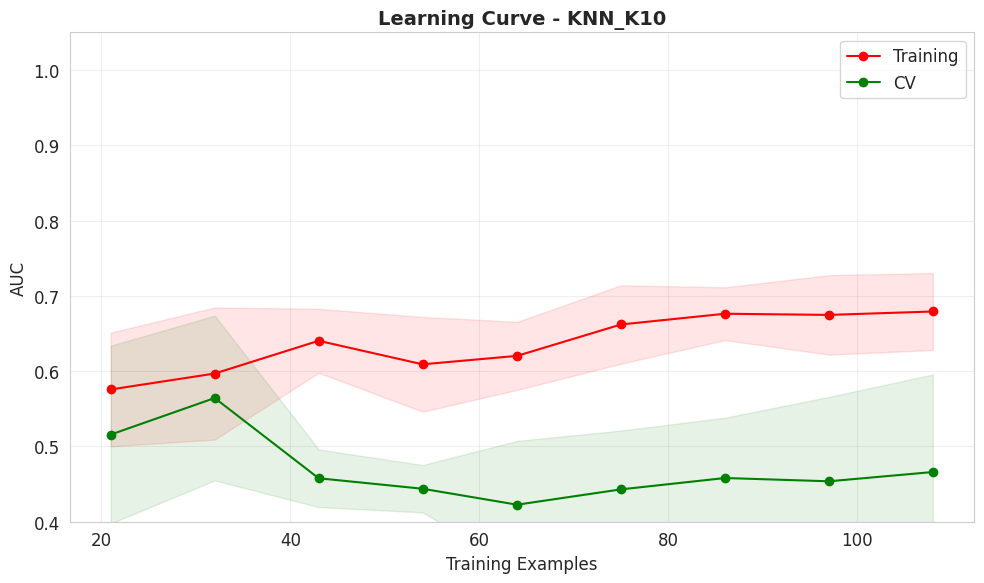

KNN_K10: Overfitting gap = 0.2132


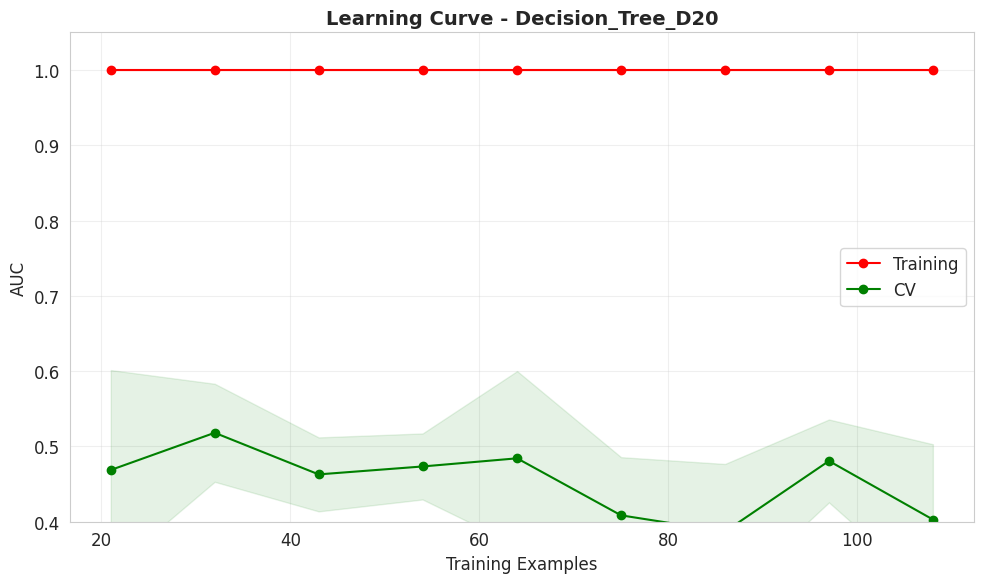

Decision_Tree_D20: Overfitting gap = 0.5971


In [23]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes, shuffle=True,
        random_state=42, scoring='roc_auc'
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f'Learning Curve - {title}', fontsize=14, weight='bold')
    plt.xlabel("Training Examples")
    plt.ylabel("AUC")
    plt.grid(alpha=0.3)
    plt.fill_between(train_sizes_abs, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_mean, 'o-', color="r", label="Training")
    plt.plot(train_sizes_abs, test_mean, 'o-', color="g", label="CV")
    plt.legend(loc="best")
    plt.ylim(0.4, 1.05)
    plt.tight_layout()
    plt.show()

    final_gap = train_mean[-1] - test_mean[-1]
    print(f"{title}: Overfitting gap = {final_gap:.4f}")

print("\n" + "="*80)
print("LEARNING CURVES - TOP 5 MODELS")
print("="*80)
top_5_names = cv_results_df.head(5)['model'].tolist()
for model_name in top_5_names:
    plot_learning_curve(models[model_name], model_name, X_train_scaled, y_train, cv=5)

## PRECISION-RECALL CURVES (TOP MODELS)

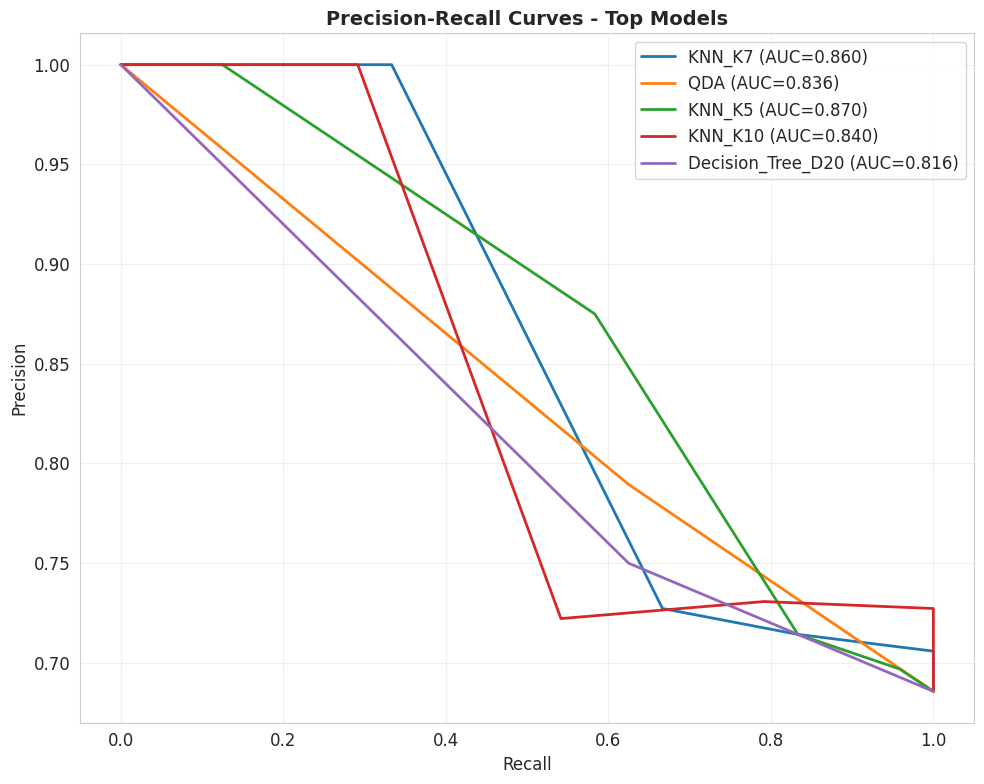

In [24]:
def plot_precision_recall_curves(models_dict, model_names, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(10, 8))
    for name in model_names:
        model = models_dict[name]
        model.fit(X_train, y_train)
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (AUC={pr_auc:.3f})', linewidth=2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves - Top Models', fontsize=14, weight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

top_5_for_pr = cv_results_df.head(5)['model'].tolist()
plot_precision_recall_curves(models, top_5_for_pr,
                             X_train_scaled, X_test_scaled, y_train, y_test)

# ENSEMBLE: VOTING + STACKING

In [25]:
print("\n" + "="*80)
print("ENSEMBLE MODELS")
print("="*80)

ensemble_candidates = cv_results_df.copy()
ensemble_candidates['Group'] = ensemble_candidates['model'].apply(assign_model_group)
top_per_group = ensemble_candidates.groupby('Group').first().reset_index()
top_models_for_ensemble = top_per_group.nlargest(5, 'auc_mean')

print("Selected models for ensemble:")
print(top_models_for_ensemble[['model', 'Group', 'auc_mean']].to_string(index=False))

base_estimators = [
    (row['model'], models[row['model']])
    for _, row in top_models_for_ensemble.iterrows()
]

voting_clf = VotingClassifier(
    estimators=base_estimators,
    voting='soft',
    n_jobs=-1
)
print("\n### Soft Voting Ensemble ###")
voting_metrics = evaluate_model_cv(voting_clf, X_train_scaled, y_train, cv=5)
print(f"Accuracy: {voting_metrics['acc_mean']:.4f} ± {voting_metrics['acc_std']:.4f}")
print(f"AUC: {voting_metrics['auc_mean']:.4f} ± {voting_metrics['auc_std']:.4f}")

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5,
    n_jobs=-1
)
print("\n### Stacking Ensemble ###")
stacking_metrics = evaluate_model_cv(stacking_clf, X_train_scaled, y_train, cv=5)
print(f"Accuracy: {stacking_metrics['acc_mean']:.4f} ± {stacking_metrics['acc_std']:.4f}")
print(f"AUC: {stacking_metrics['auc_mean']:.4f} ± {stacking_metrics['auc_std']:.4f}")

ensemble_results = pd.DataFrame([
    {'model': 'Voting_Ensemble', **voting_metrics},
    {'model': 'Stacking_Ensemble', **stacking_metrics}
])
cv_results_df = pd.concat([cv_results_df, ensemble_results], ignore_index=True)
cv_results_df = cv_results_df.sort_values('auc_mean', ascending=False).reset_index(drop=True)


ENSEMBLE MODELS
Selected models for ensemble:
            model                      Group  auc_mean
           KNN_K7                        KNN  0.519948
              QDA      Discriminant Analysis  0.510396
Decision_Tree_D20                Single Tree  0.484795
     AdaBoost_N50         Boosting Ensembles  0.460559
 Extra_Trees_N100 Random Forest / ExtraTrees  0.445354

### Soft Voting Ensemble ###
Accuracy: 0.5368 ± 0.0497
AUC: 0.4995 ± 0.1208

### Stacking Ensemble ###
Accuracy: 0.6616 ± 0.0167
AUC: 0.4533 ± 0.0818
